# Poly Prep
Cascade Tuholske Dec 2020


In [78]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from rasterio import features
import rasterio
import rasterio.mask
from skimage.filters import rank

In [20]:
# file paths 
data_in = '/Users/cascade/Github/PopGridCompare/data/raw/'
data_out = '/Users/cascade/Github/PopGridCompare/data/interim/'

## Dissolve polygons for Mozambique, Zimbabwe & Malawai 

In [3]:
# polys in
zwe = gpd.read_file(data_in+'GDAM/gadm36_ZWE_shp/gadm36_ZWE_0.shp')
mwi = gpd.read_file(data_in+'GDAM/gadm36_MWI_shp/gadm36_MWI_0.shp')
moz = gpd.read_file(data_in+'GDAM/gadm36_MOZ_shp/gadm36_MOZ_0.shp')

In [4]:
dfs = [zwe, mwi, moz]
polys = gpd.GeoDataFrame(pd.concat(dfs))

,GID_0,NAME_0,geometry
0,ZWE,Zimbabwe,"POLYGON ((31.05947 -22.33982, 31.05900 -22.339..."
0,MWI,Malawi,"MULTIPOLYGON (((34.75042 -12.06486, 34.75042 -..."
0,MOZ,Mozambique,"MULTIPOLYGON (((32.88820 -26.28681, 32.88820 -..."


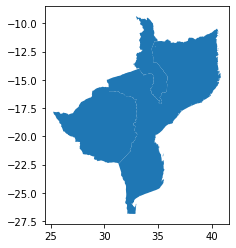

In [5]:
polys.plot()
polys.head()

In [6]:
# Dissolve 
polys['ID'] = 'M-M-Z'
diss = polys.dissolve(by = 'ID')

<AxesSubplot:>

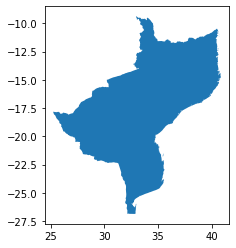

In [7]:
diss.plot()

In [8]:
# write
diss.to_file(data_out+'M-M-Z.shp')

## Drop Islands for Ecuador

In [71]:
# polys in
ecu = gpd.read_file(data_in+'GDAM/gadm36_ECU_shp/gadm36_ECU_0.shp')
flood = gpd.read_file(data_in+'ECU-Floods/Susceptibility/FF_suscept_PCA.shp')
fn_out = data_out+'ECU-clip.shp'

In [47]:
# change crs
flood = flood.to_crs(ecu.crs)

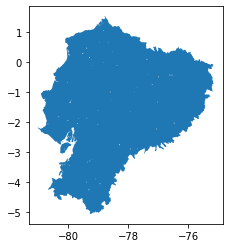

In [48]:
# dissolve floods and get bounding box
flood['ID'] = 'ECU'
diss = flood.dissolve(by = 'ID')
diss.plot()
bb = box(*diss.total_bounds)

In [64]:
# make bb a geodata frame
df = pd.DataFrame(['ECU'])
df['geometry'] = bb
bb_gdf = gpd.GeoDataFrame(df).buffer(1)

<AxesSubplot:>

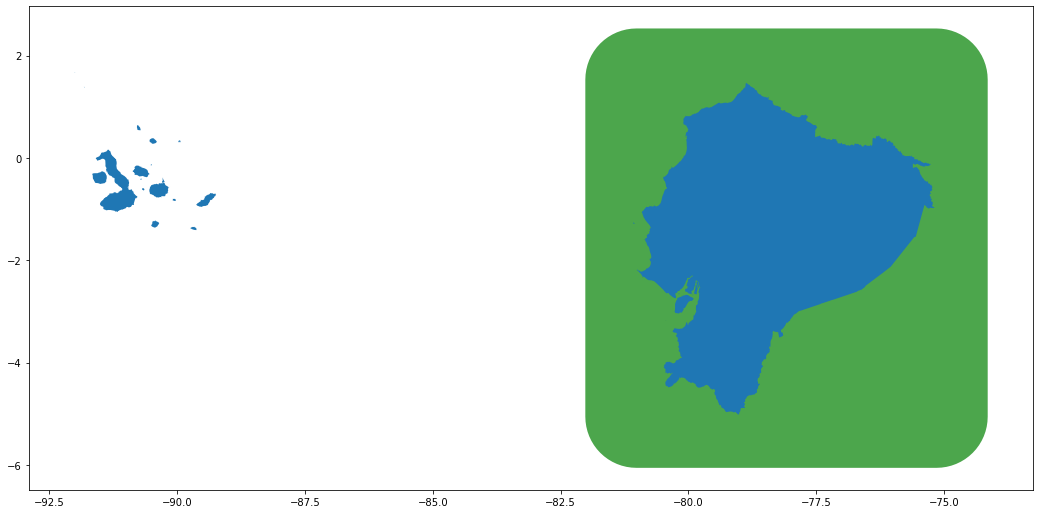

In [65]:
# plot them

axs = bb_gdf.plot(color = 'green', alpha = 0.7, figsize = (18, 18))
ecu.plot(ax = axs, figsize = (8, 8))

In [68]:
bb_gdf.crs

<ipython-input-70-5890facbf9ad>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  clip = gpd.clip(ecu, bb_gdf)


<AxesSubplot:>

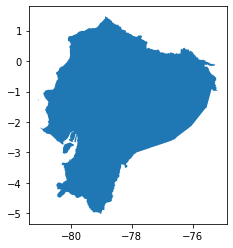

In [70]:
# clip to buffer (will throw warning; that's ok)
clip = gpd.clip(ecu, bb_gdf)
clip.plot()

In [72]:
clip.to_file(fn_out)

## Turn GDAM polygons into raster bianaries

In [1]:
def poly_to_raster (rst, polys, value, touched, out_fn, fill_value):
    """Function makes a raster from a list of polygons
    
    Args:   rst = input raster already read in as a rasterio object to act as a template
            polys = input polygons already read in as a gpd dataframe
            value = col with value to burn into raster
            touched = bool, if True all pixels touched (not centers) are burned into raster
            out_fn = out file name 
            fill_value = value to revalue input raster before burning in polygons 
    
    """

    meta = rst.meta.copy() # copy meta data from rst
    out_arr = rst.read(1) # get an array to burn shapes
    out_arr.fill(fill_value) # revalue rst to an Nan Value before burning in polygons
    
    # extract geom and values to burn
    shapes = ((geom,value) for geom, value in zip(polys['geometry'], polys[value])) 
    
    # burn shapes intp an array
    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=rst.transform, all_touched=touched)
    
    # write our raster to disk
    with rasterio.open(out_fn, 'w', **meta) as out:
        out.write_band(1, burned)

In [31]:
def raster_clip(rst_in, polys, rst_out):
    
    """ function clips a raster and saves it out
    args:
        rst_in = raster you want to clip
        polys = polys you want to clip to
        rst_out = name of clipped raster
    """
    
    # clip raster
    with rasterio.open(rst_fn) as src:
        out_image, out_transform = rasterio.mask.mask(src, polys, crop=True, nodata = 0)
        out_meta = src.meta
        
    # Update meta data
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    
    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(out_image)

In [53]:
# polygons to burn
# GDAM/gadm36_NPL_shp
polys = gpd.read_file(data_in+'GDAM/gadm36_NPL_shp/gadm36_NPL_0.shp')

# update columns
polys = polys[['geometry']]
polys['value'] = 1

fn_out = data_out+'Nepal-rst.tif'

In [54]:
rst = rasterio.open(data_in+'gpw_v4/gpw-v4-population-count-rev11_2015_30_sec_tif/gpw_v4_population_count_rev11_2015_30_sec.tif')
value = 'value'
touched = False # see rasterio documentation, using un-touched in this analysis 
fill_value = 0

In [55]:
poly_to_raster(rst, polys, value, touched, fn_out, fill_value)

In [56]:
# Now clip the raster
rst_fn = fn_out
rst_out = fn_out
polys = polys['geometry']

raster_clip(rst_fn, polys, rst_out)

## Idai Flood Raster
Data from human data exchange, at 30m resolution values = 1 & 255 <br>
Need to resample with a majority filter at 1-km

In [ ]:
def resample(fn_in, fn_out, scale_factor, method):
    
    """ Resamples a raster and save it out
    Args:
        fn_in = file path and name of tif input as str
        fn_out = file path and name of tif output as str 
        scale_factor = factor to up or down scale a pixel as float
        method = method to resample (rasterio object), see rasterio documentation
    """
    
    with rasterio.open(fn_in) as dataset:

        # resample data to target shape
        data = dataset.read(
            out_shape=(
                dataset.count,
                int(dataset.height * scale_factor),
                int(dataset.width * scale_factor)
            ),
            resampling=method
        )

        # scale image transform
        transform = dataset.transform * dataset.transform.scale(
            (dataset.width / data.shape[-1]),
            (dataset.height / data.shape[-2])
        )
    
    # meta data to write out
    out_meta = dataset.meta

    # Update meta data
    out_meta.update({"driver": "GTiff",
             "height": data.shape[1],
             "width": data.shape[2],
             "transform": transform})

    # write image 
    with rasterio.open(fn_out, "w", **out_meta) as dest:
        dest.write(data)

In [146]:
# Majority filter
rst_fn = data_in+'Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif'
fn_out = data_out+'Idai_flood1km.tif'`

In [157]:
resample(rst_fn, fn_out, scale_factor = 3/100, method = 'mode')

NameError: name 'resample' is not defined

In [147]:
rasterio.open(rst_fn).meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 8610,
 'height': 7757,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(95.13579262455364, 0.0, 3500648.1262464076,
        0.0, -95.13763951272966, -1663877.0266072527)}

In [150]:
3/ 100

0.03

In [155]:
import rasterio
from rasterio.enums import Resampling
# https://rasterio.readthedocs.io/en/latest/topics/resampling.html

downscale_factor = 3/100

with rasterio.open(rst_fn) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * downscale_factor),
            int(dataset.width * downscale_factor)
        ),
        resampling=Resampling.mode
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [156]:
data.shape

(1, 232, 258)

In [ ]:
# write image 
out_meta
with rasterio.open(fn_out, "w", **out_meta) as dest:
     dest.write(out_image)

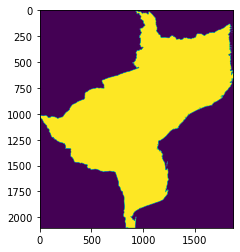

In [133]:
plt.imshow(rst.read(1))

In [123]:
rst_fn = data_in+'Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif'
fn_out = data_out+'Idai_flood1km.tif'

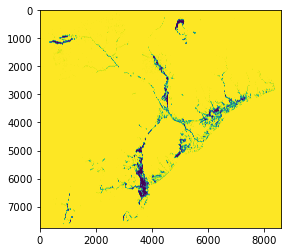

In [75]:
plt.imshow(rst.read(1))

In [79]:
arr_in = rst.read(1)

In [138]:
arr_in.shape

(7757, 8610)

In [110]:
mask = np.ones((33,33)) 
mask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [111]:
arr_out = rank.majority(arr_in, mask)

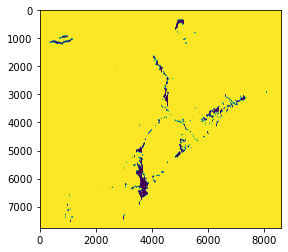

In [113]:
plt.imshow(arr_out)

In [137]:
arr_out.shape

(7757, 8610)

In [141]:
# write out raster
rst_fn = data_out+'M-M-Z-rst.tif'
fn_out = 'Idai_flood1km.tif'

with rasterio.open(rst_fn) as src:
    out_meta = src.meta

# # Update meta data
# out_meta.update({"driver": "GTiff",
#              "height": arr_out.shape[1],
#              "width": arr_out.shape[2]})

# # write image 
# with rasterio.open(fn_out, "w", **out_meta) as dest:
#     dest.write(out_image)

In [142]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 1873,
 'height': 2102,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00833333333333333, 0.0, 25.233333333333235,
        0.0, -0.00833333333333333, -9.358333333333377)}

In [140]:
# Majority filter
rst_fn = data_in+'Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif'
fn_out = data_out+'Idai_flood-majority filter.tif'

from whitebox_tools import WhiteboxTools

wbt = WhiteboxTools()
wbt.majority_filter(rst_fn, fn_out, filterx=33, filtery=33)





./whitebox_tools --run="MajorityFilter" --input='/Users/cascade/Github/PopGridCompare/data/raw/Idai/HDX/moz_totalfloodextent/MOZ_TotalFloodExtent12to2.tif' --output='/Users/cascade/Github/PopGridCompare/data/interim/Idai_flood-majority filter.tif' --filterx=33 --filtery=33 -v

*****************************
* Welcome to MajorityFilter *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Progress: 43%
Progress: 

0